# Applying `REINFORCE` to the Navigation Environment

This is a simple adaptation of my example implementation of `REINFORCE` to the **Navigation Environment**.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

And also some utility functions useful for what comes next.

In [2]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500, device='cpu'):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

## The Policy network

This is the same policy network used in the **Q-Learning** implementation for the two policy and target Q-Networks.

In [3]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, env.action_space.n)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.relu(self.fc2(s))
        s = F.softmax(self.fc3(s), dim=-1)
        return s

## The `REINFORCE` Algorithm

This is a very simple implementation of the most basic policy gradient DRL algorithm: `REINFORCE`. It is a very direct implementation of the policy gradient update (although I use Adam instead of SGD).

In [6]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, lr=1e-4, num_episodes=10, device='cpu'):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=lr)

    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy, device=device)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.005 * returns[0].item() + 0.995 * running_rewards[-1])
        
        # Standardize returns.
        returns = (returns - returns.mean()) / (returns.std() + 1e-6)
        
        # Make an optimization step
        log_probs = log_probs.to(device)
        returns = returns.to(device)
        opt.zero_grad()
        loss = (-log_probs * returns).sum()
        loss.backward()
        opt.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 500:
            policy.eval()
            (obs, _, _, _) = run_episode(env_render, policy, device=device)
            policy.train()
            print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    return running_rewards

Running reward: -0.4705095672607422
Running reward: -47.068951225164575
Running reward: -60.20051313797983
Running reward: -50.81008205660788
Running reward: -40.99750492330718
Running reward: -31.412896008526
Running reward: -17.68264915630676
Running reward: 33.72511290638004
Running reward: 52.958425552100245
Running reward: 74.45675529328639
Running reward: 1.2892448425292968
Running reward: 54.25552703780374
Running reward: 70.79843904775673
Running reward: 85.2838113136786
Running reward: 76.30381577250654
Running reward: 89.20432763382334
Running reward: 78.00463900346098
Running reward: 90.39858469877518
Running reward: 92.4844295438706
Running reward: 95.62892536055817


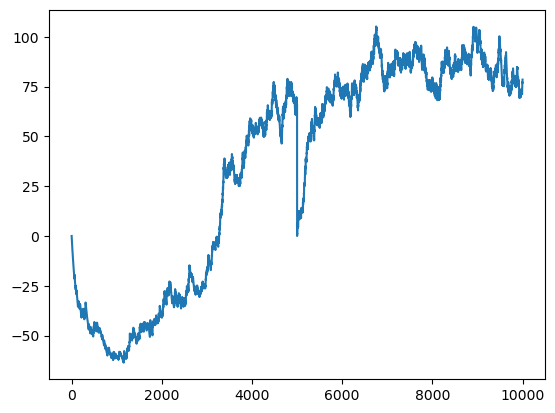

In [14]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

env = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode=None, track_id=1)
env_render = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode='human')

# Make a policy network.
policy = PolicyNet(env).to(device)

# Train the agent.
running  = reinforce(policy, env, env_render, device=device, lr=1e-4, num_episodes=5000)
running += reinforce(policy, env, env_render, device=device, lr=1e-5, num_episodes=5000)
plt.plot(running)

# Close up everything
env_render.close()
env.close()

In [15]:
# And run the final agent for a few episodes.
env_render = gymnasium.make('gym_navigation:NavigationGoal-v0', render_mode='human')
for _ in range(10):
    (_, _, _, r) = run_episode(env_render, policy, device=device)
    returns = compute_returns(r, 0.99)
    print(returns[0])
env_render.close()

-89.8894063500042
-83.10625607908315
-13.471453427368663
369.11430518648905
-30.37377875242762
-60.32006466266593
-32.92814715527686


KeyboardInterrupt: 

## For your consideration

There are many things that can be improved in this example. Some things you can think about:

1. **Replay**. In the current implementation we execute an episode, and then immediately run an optimization step on all of the steps of the episode. Not only are we using *correlated* samples from a single episode, we are decidedly *not* taking advantage of parallelism via batch gradient descent. Note that `REINFORCE` does **not** require entire trajectories, all we need are the discounted rewards and log probabilities for *individual transitions*.

2. **Exploration**. The model is probably overfitting (or perhaps remaining too *plastic*, which can explain the unstable convergence). Our policy is *always* stochastic in that we sample from the output distribution. It would be interesting to add a temperature parameter to the policy so that we can control this behavior, or even implement a deterministic policy sampler that always selects the action with max probability to evaluate the quality of the learned policy network.

3. **Discount Factor**: The discount factor (default $\gamma = 0.99$) is an important hyperparameter that has an effect on the stability of training. Try different values for $\gamma$ and see how it affects training. Can you think of other ways to stabilize training?